In [262]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Import Statsmodels
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

In [263]:
df = pd.read_csv('Final dataset.csv')

In [264]:
df['Date']=pd.to_datetime(df['Date'])

In [265]:
df.set_index('Date', inplace=True)

In [266]:
df=df.dropna()

In [267]:
df=df.iloc[:103,:]

In [268]:
df

,CPI,Median Annual Income,Population Estimate,Petrol Price,Diesel Price,Google Search Index,All Cars,ULEV
Date,,,,,,,,
2011-10-31,94.5,26719.28962,430572.0765,1.3473,1.4027,23,268565,19
2011-11-30,94.6,26652.97814,430979.3716,1.3317,1.4110,22,268412,19
2011-12-31,95.1,26584.45628,431400.2432,1.3241,1.4077,12,268254,20
2012-01-31,94.6,26515.93443,431821.1148,1.3410,1.4245,21,268096,22
2012-02-29,95.1,26451.83333,432214.8333,1.3621,1.4392,26,265633,23
...,...,...,...,...,...,...,...,...
2019-12-31,108.5,32258.97541,465043.1339,1.2496,1.3054,75,334286,4143
2020-01-31,108.2,32444.21311,465253.9508,1.2733,1.3288,85,337029,4351
2020-02-29,108.6,32617.50000,465451.1667,1.2345,1.2767,100,334862,4434


In [269]:
df=df.drop(columns=['Petrol Price', 'Diesel Price'])

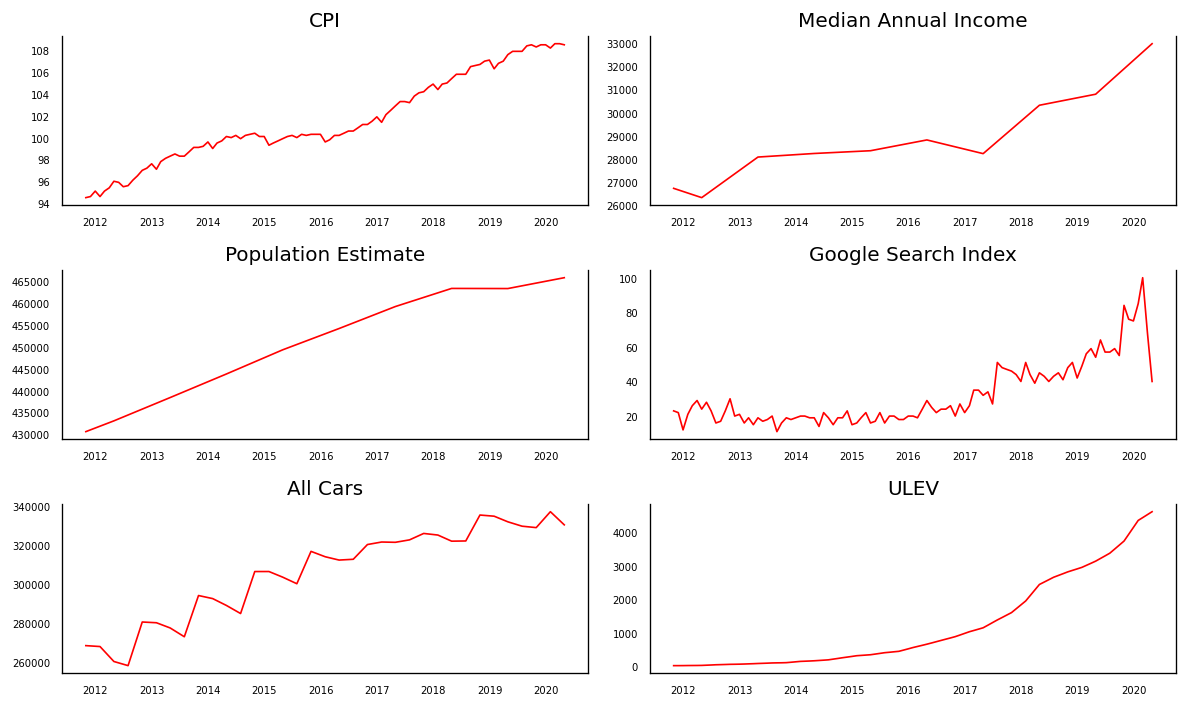

In [270]:
fig, axes = plt.subplots(nrows=3, ncols=2, dpi=120, figsize=(10,6))
for i, ax in enumerate(axes.flatten()):
    data = df[df.columns[i]]
    ax.plot(data, color='red', linewidth=1)
    # Decorations
    ax.set_title(df.columns[i])
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();

In [271]:
from statsmodels.tsa.stattools import grangercausalitytests
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

grangers_causation_matrix(df, variables = df.columns)        


,CPI_x,Median Annual Income_x,Population Estimate_x,Google Search Index_x,All Cars_x,ULEV_x
CPI_y,1.0000,0.2729,0.0018,0.0250,0.0000,0.1733
Median Annual Income_y,0.0043,1.0000,0.2108,0.0000,0.0322,0.0000
Population Estimate_y,0.0000,0.0000,1.0000,0.0000,0.0006,0.0000
Google Search Index_y,0.0010,0.0001,0.0108,1.0000,0.0176,0.0000
All Cars_y,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000
ULEV_y,0.0122,0.0025,0.0000,0.0006,0.0196,1.0000


In [272]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df, alpha=0.05): 
    """Perform Johanson's Cointegration Test and Report Summary"""
    out = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = out.lr1
    cvts = out.cvt[:, d[str(1-alpha)]]
    def adjust(val, length= 6): return str(val).ljust(length)

    # Summary
    print('Name   ::  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), ':: ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)

cointegration_test(df)

Name   ::  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
CPI    ::  167.61    > 83.9383   =>   True
Median Annual Income ::  104.11    > 60.0627   =>   True
Population Estimate ::  55.66     > 40.1749   =>   True
Google Search Index ::  29.55     > 24.2761   =>   True
All Cars ::  7.52      > 12.3212   =>   False
ULEV   ::  0.58      > 4.1296    =>   False


In [273]:
df.shape

(103, 6)

In [274]:
nobs = 5
df_train, df_test = df[0:-nobs], df[-nobs:]

# Check size
print(df_train.shape)  # (119, 8)
print(df_test.shape)  # (4, 8)

(98, 6)
(5, 6)


In [275]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    


In [276]:
for name, column in df_train.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "CPI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.2882
 No. Lags Chosen       = 12
 Critical value 1%     = -3.51
 Critical value 5%     = -2.896
 Critical value 10%    = -2.585
 => P-Value = 0.9272. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Median Annual Income" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -0.0771
 No. Lags Chosen       = 1
 Critical value 1%     = -3.5
 Critical value 5%     = -2.892
 Critical value 10%    = -2.583
 => P-Value = 0.9517. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Population Estimate" 
    -----------------------------------------------
 Null 

In [277]:
#1st differentiation
df_differenced = df_train.diff().dropna()
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "CPI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.1783
 No. Lags Chosen       = 11
 Critical value 1%     = -3.51
 Critical value 5%     = -2.896
 Critical value 10%    = -2.585
 => P-Value = 0.6829. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Median Annual Income" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.0078
 No. Lags Chosen       = 12
 Critical value 1%     = -3.511
 Critical value 5%     = -2.897
 Critical value 10%    = -2.585
 => P-Value = 0.7504. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "Population Estimate" 
    -----------------------------------------------
 Nu

In [278]:
#2nd differentiation
df_differenced = df_differenced.diff().dropna()
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.iteritems():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "CPI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -3.6534
 No. Lags Chosen       = 12
 Critical value 1%     = -3.512
 Critical value 5%     = -2.897
 Critical value 10%    = -2.586
 => P-Value = 0.0048. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Median Annual Income" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.8338
 No. Lags Chosen       = 11
 Critical value 1%     = -3.511
 Critical value 5%     = -2.897
 Critical value 10%    = -2.585
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "Population Estimate" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Station

In [279]:
model = VAR(df_differenced)
for i in [1,2,3,4,5,6,7,8,9]:
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  38.32091938523765
BIC :  39.450001800471576
FPE :  4.398059249027825e+16
HQIC:  38.777153390259016 

Lag Order = 2
AIC :  38.200564313850315
BIC :  40.310957856585
FPE :  3.934982507893235e+16
HQIC:  39.05300884153606 

Lag Order = 3
AIC :  37.85303026264472
BIC :  40.95750706070355
FPE :  2.8481183269185076e+16
HQIC:  39.10652918841804 

Lag Order = 4
AIC :  38.358775554418095
BIC :  42.47038736482414
FPE :  4.960132200641156e+16
HQIC:  40.018256918965996 

Lag Order = 5
AIC :  38.2272468833389
BIC :  43.359333347208505
FPE :  4.739976617078502e+16
HQIC:  40.29772412891108 

Lag Order = 6
AIC :  36.35720104730892
BIC :  42.52339823412357
FPE :  8401937688953369.0
HQIC:  38.84377420928043 

Lag Order = 7
AIC :  36.54435803113728
BIC :  43.758607282720334
FPE :  1.2588604296652434e+16
HQIC:  39.45221487517072 

Lag Order = 8
AIC :  36.0815532869231
BIC :  44.35811037165712
FPE :  1.1017383993509278e+16
HQIC:  39.41597038082317 

Lag Order = 9
AIC :  32.4322056958196

C:\Users\anich\anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  warnings.warn('No frequency information was'


In [280]:
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 31, Mar, 2022
Time:                     16:51:54
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    40.9575
Nobs:                     93.0000    HQIC:                   39.1065
Log likelihood:          -2437.93    FPE:                2.84812e+16
AIC:                      37.8530    Det(Omega_mle):     9.33571e+15
--------------------------------------------------------------------
Results for equation CPI
                             coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------
const                           0.000639         0.036088            0.018           0.986
L1.CPI                         -0.787762         0.104587           -7.532           0.000
L1.Median Annual Incom

In [281]:
from statsmodels.stats.stattools import durbin_watson
out = durbin_watson(model_fitted.resid)

for col, val in zip(df.columns, out):
    print(':', round(val, 2))

: 2.14
: 1.96
: 2.02
: 2.18
: 2.02
: 1.82


In [282]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

3


array([[-4.00000e-01, -5.97542e+00, -6.80050e+00, -6.00000e+00,
         7.00000e+00, -3.00000e+00],
       [-3.00000e-01,  5.97542e+00,  6.80050e+00,  3.30000e+01,
        -6.00000e+00,  4.00000e+00],
       [ 4.00000e-01, -5.97542e+00, -6.80050e+00, -3.70000e+01,
         2.89800e+03,  7.80000e+01]])

In [283]:
# Forecast
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=df.index[-nobs:], columns=df.columns + '_2d')
df_forecast

,CPI_2d,Median Annual Income_2d,Population Estimate_2d,Google Search Index_2d,All Cars_2d,ULEV_2d
Date,,,,,,
2019-12-31,0.132098,-0.418570,15.477911,18.945514,-574.775070,11.582980
2020-01-31,-0.090645,23.499839,19.767587,20.336532,1533.425806,-7.297935
2020-02-29,-0.388421,-75.336851,-148.252508,-30.038699,-1611.649082,-15.116763
2020-03-31,0.517461,2.529972,30.469643,11.485621,-693.829767,11.096769
2020-04-30,-0.343524,31.061012,31.355817,7.974787,976.707377,4.665338


In [284]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [285]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['CPI_forecast', 'Median Annual Income_forecast', 'Population Estimate_forecast', 'Google Search Index_forecast', 'All Cars_forecast', 'ULEV_forecast']]

,CPI_forecast,Median Annual Income_forecast,Population Estimate_forecast,Google Search Index_forecast,All Cars_forecast,ULEV_forecast
Date,,,,,,
2019-12-31,108.832098,32252.581420,465051.811211,86.945514,333622.224930,4146.582980
2020-01-31,109.073550,32454.924979,465291.073108,118.227559,337233.875666,4350.868024
2020-02-29,108.926582,32581.931688,465382.082497,119.470905,339233.877320,4540.036305
2020-03-31,109.297074,32711.468368,465503.561529,132.199873,340540.049207,4740.301355
2020-04-30,109.324043,32872.066060,465656.396378,152.903627,342822.928471,4945.231743


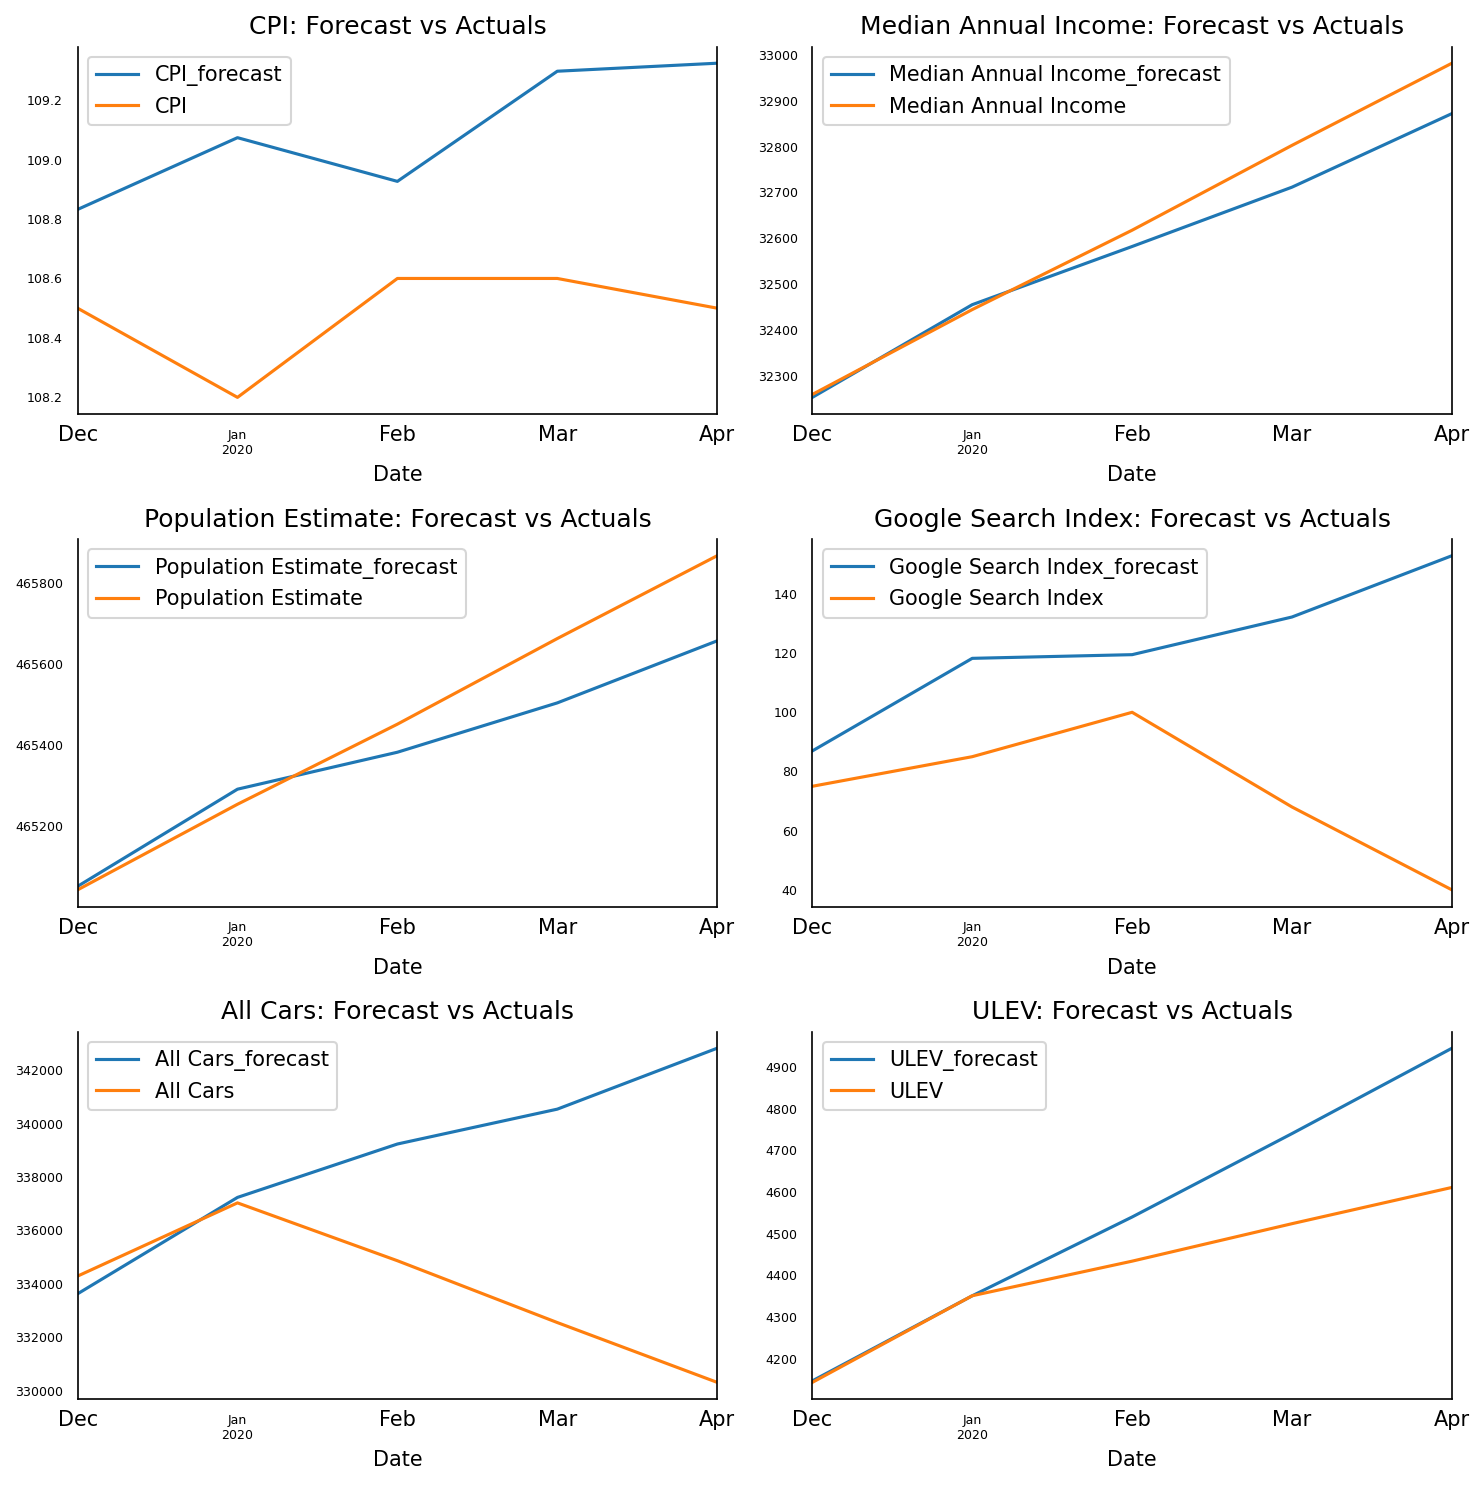

In [286]:
fig, axes = plt.subplots(nrows=int(len(df.columns)/2), ncols=2, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(df.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();